This is a simple example on how you can use a jupyter notebook to train your model :) 

In [25]:
import torch
import torch.nn as nn
import torchvision as tv
#from dataloaders import load_cifar10
from trainer import Trainer, compute_loss_and_accuracy
from task2 import create_plots
#Task 4 stuff
from dataloaders import get_data_dir
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import typing

In [26]:
#normalize = tv.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

#Taken from dataloader
def load_cifar10(batch_size: int, validation_fraction: float = 0.1
                 ) -> typing.List[torch.utils.data.DataLoader]:
    # Note that transform train will apply the same transform for
    # validation!
    transform_train = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Resize([112,112]),
        tv.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    ])
    transform_test = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Resize([112,112]),
        tv.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
    data_train = tv.datasets.CIFAR10(get_data_dir(),
                                  train=True,
                                  download=True,
                                  transform=transform_train)

    data_test = tv.datasets.CIFAR10(get_data_dir(),
                                 train=False,
                                 download=True,
                                 transform=transform_test)

    indices = list(range(len(data_train)))
    split_idx = int(np.floor(validation_fraction * len(data_train)))

    val_indices = np.random.choice(indices, size=split_idx, replace=False)
    train_indices = list(set(indices) - set(val_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)

    dataloader_train = torch.utils.data.DataLoader(data_train,
                                                   sampler=train_sampler,
                                                   batch_size=batch_size,
                                                   num_workers=0,
                                                   drop_last=True)

    dataloader_val = torch.utils.data.DataLoader(data_train,
                                                 sampler=validation_sampler,
                                                 batch_size=batch_size,
                                                 num_workers=0)

    dataloader_test = torch.utils.data.DataLoader(data_test,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=0)

    return dataloader_train, dataloader_val, dataloader_test

In [27]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = tv.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, 10)              # No need to apply softmax,
        # as this is done in nn.CrossEntropyLoss
        for param in self.model.parameters():           # Freeze all parameters
            param.requires_grad = False
        for param in self.model.fc.parameters():        # Unfreeze the last fully-connected
            param.requires_grad = True                  # layer
        for param in self.model.layer4.parameters():    # Unfreeze the last 5 convolutional
            param.requires_grad = True                  # layers

    def forward(self, x):
        x = self.model(x)
        return x

In [28]:
epochs = 10
batch_size = 32
learning_rate = 5e-4 # Should be 5e-5 for LeNet
early_stop_count = 4
dataloaders = load_cifar10(batch_size)
model = Model()
#torch.optim.Adam(Model.parameters(), lr = 5e-5, betas = (0.9, 0.999), eps = 1e-08, weight_deca = 0, amsgrad=False)
trainer = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model,
    dataloaders
)
trainer.train()

Files already downloaded and verified
Files already downloaded and verified
Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

In [29]:
#Calculate train, test and validation accuracy
model.eval()
test = trainer.dataloader_test
train = trainer.dataloader_train
val = trainer.dataloader_val
print(compute_loss_and_accuracy(val, model = model, loss_criterion = nn.CrossEntropyLoss()))
print(compute_loss_and_accuracy(test, model = model, loss_criterion = nn.CrossEntropyLoss()))
print(compute_loss_and_accuracy(train, model = model, loss_criterion = nn.CrossEntropyLoss()))

(tensor(0.3841, device='cuda:0'), 0.8666)
(tensor(0.4023, device='cuda:0'), 0.8618)
(tensor(0.3023, device='cuda:0'), 0.8988486842105263)


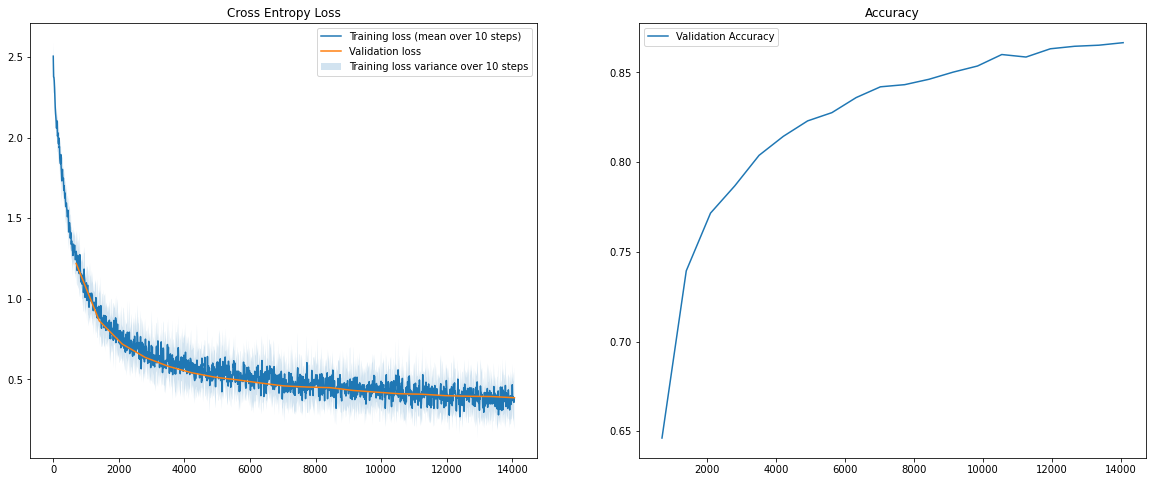

In [30]:
create_plots(trainer, "overwrite")